In [1]:
from voxelwise_tutorials.io import get_data_home
directory = get_data_home(dataset="shortclips")
print(directory)

/home/jlg/yuerou/voxelwise_tutorials_data/shortclips


In [2]:
# modify to use another subject
subject = "S01"

In [3]:
import os
import numpy as np
from voxelwise_tutorials.io import load_hdf5_array

file_name = os.path.join(directory, "responses", f"{subject}_responses.hdf")
Y_train = load_hdf5_array(file_name, key="Y_train")
Y_test = load_hdf5_array(file_name, key="Y_test")

print("(n_samples_train, n_voxels) =", Y_train.shape)
print("(n_repeats, n_samples_test, n_voxels) =", Y_test.shape)

(n_samples_train, n_voxels) = (3600, 84038)
(n_repeats, n_samples_test, n_voxels) = (10, 270, 84038)


In [4]:
from voxelwise_tutorials.utils import explainable_variance
ev = explainable_variance(Y_test)
print("(n_voxels,) =", ev.shape)

mask = ev > 0.1
print("(n_voxels_mask,) =", ev[mask].shape)

(n_voxels,) = (84038,)
(n_voxels_mask,) = (6849,)


In [5]:
Y_test = Y_test.mean(0)

print("(n_samples_test, n_voxels) =", Y_test.shape)

(n_samples_test, n_voxels) = (270, 84038)


In [6]:
Y_train = np.nan_to_num(Y_train)
Y_test = np.nan_to_num(Y_test)

In [7]:
Y_train -= Y_train.mean(0)
Y_test -= Y_test.mean(0)

In [8]:
feature_names = ["wordnet", "motion_energy"]

Xs_train = []
Xs_test = []
n_features_list = []
for feature_space in feature_names:
    file_name = os.path.join(directory, "features", f"{feature_space}.hdf")
    Xi_train = load_hdf5_array(file_name, key="X_train")
    Xi_test = load_hdf5_array(file_name, key="X_test")

    Xs_train.append(Xi_train.astype(dtype="float32"))
    Xs_test.append(Xi_test.astype(dtype="float32"))
    n_features_list.append(Xi_train.shape[1])

# concatenate the feature spaces
X_train = np.concatenate(Xs_train, 1)
X_test = np.concatenate(Xs_test, 1)

print("(n_samples_train, n_features_total) =", X_train.shape)
print("(n_samples_test, n_features_total) =", X_test.shape)
print("[n_features_wordnet, n_features_motion_energy] =", n_features_list)

(n_samples_train, n_features_total) = (3600, 8260)
(n_samples_test, n_features_total) = (270, 8260)
[n_features_wordnet, n_features_motion_energy] = [1705, 6555]


In [9]:
from sklearn.model_selection import check_cv
from voxelwise_tutorials.utils import generate_leave_one_run_out

# indice of first sample of each run
run_onsets = load_hdf5_array(file_name, key="run_onsets")
print(run_onsets)

[   0  300  600  900 1200 1500 1800 2100 2400 2700 3000 3300]


In [10]:
n_samples_train = X_train.shape[0]
cv = generate_leave_one_run_out(n_samples_train, run_onsets)
cv = check_cv(cv)  # copy the cross-validation splitter into a reusable list

In [11]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from voxelwise_tutorials.delayer import Delayer
from himalaya.backend import set_backend
backend = set_backend("torch_cuda", on_error="warn")

/home/jlg/yuerou/anaconda3/envs/book5/lib/python3.9/site-packages/himalaya/backend/_utils.py:55: UserWarning: Setting backend to torch_cuda failed: PyTorch not installed..Falling back to numpy backend.
  warnings.warn(f"Setting backend to {backend} failed: {str(error)}."


In [12]:
from himalaya.kernel_ridge import MultipleKernelRidgeCV

# Here we will use the "random_search" solver.
solver = "random_search"

# We can check its specific parameters in the function docstring:
solver_function = MultipleKernelRidgeCV.ALL_SOLVERS[solver]
print("Docstring of the function %s:" % solver_function.__name__)
print(solver_function.__doc__)

Docstring of the function solve_multiple_kernel_ridge_random_search:
Solve multiple kernel ridge regression using random search.

    Parameters
    ----------
    Ks : array of shape (n_kernels, n_samples, n_samples)
        Input kernels.
    Y : array of shape (n_samples, n_targets)
        Target data.
    n_iter : int, or array of shape (n_iter, n_kernels)
        Number of kernel weights combination to search.
        If an array is given, the solver uses it as the list of kernel weights
        to try, instead of sampling from a Dirichlet distribution. Examples:
          - `n_iter=np.eye(n_kernels)` implement a winner-take-all strategy
            over kernels.
          - `n_iter=np.ones((1, n_kernels))/n_kernels` solves a (standard)
            kernel ridge regression.
    concentration : float, or list of float
        Concentration parameters of the Dirichlet distribution.
        If a list, iteratively cycle through the list.
        Not used if n_iter is an array.
    alp

In [13]:
n_iter = 20

alphas = np.logspace(1, 20, 20)

In [14]:
n_targets_batch = 200
n_alphas_batch = 5
n_targets_batch_refit = 200

In [15]:
solver_params = dict(n_iter=n_iter, alphas=alphas,
                     n_targets_batch=n_targets_batch,
                     n_alphas_batch=n_alphas_batch,
                     n_targets_batch_refit=n_targets_batch_refit)

mkr_model = MultipleKernelRidgeCV(kernels="precomputed", solver=solver,
                                  solver_params=solver_params, cv=cv)

In [16]:
from himalaya.kernel_ridge import Kernelizer
from sklearn import set_config
set_config(display='diagram')  # requires scikit-learn 0.23

preprocess_pipeline = make_pipeline(
    StandardScaler(with_mean=True, with_std=False),
    Delayer(delays=[1, 2, 3, 4]),
    Kernelizer(kernel="linear"),
)
preprocess_pipeline

Pipeline(steps=[('standardscaler', StandardScaler(with_std=False)),
                ('delayer', Delayer(delays=[1, 2, 3, 4])),
                ('kernelizer', Kernelizer())])

In [17]:
from himalaya.kernel_ridge import ColumnKernelizer

# Find the start and end of each feature space in the concatenated ``X_train``.
start_and_end = np.concatenate([[0], np.cumsum(n_features_list)])
slices = [
    slice(start, end)
    for start, end in zip(start_and_end[:-1], start_and_end[1:])
]
slices

[slice(0, 1705, None), slice(1705, 8260, None)]

In [18]:
kernelizers_tuples = [(name, preprocess_pipeline, slice_)
                      for name, slice_ in zip(feature_names, slices)]
column_kernelizer = ColumnKernelizer(kernelizers_tuples)
column_kernelizer

# (Note that ``ColumnKernelizer`` has a parameter ``n_jobs`` to parallelize
# each ``Kernelizer``, yet such parallelism does not work with GPU arrays.)

ColumnKernelizer(transformers=[('wordnet',
                                Pipeline(steps=[('standardscaler',
                                                 StandardScaler(with_std=False)),
                                                ('delayer',
                                                 Delayer(delays=[1, 2, 3, 4])),
                                                ('kernelizer', Kernelizer())]),
                                slice(0, 1705, None)),
                               ('motion_energy',
                                Pipeline(steps=[('standardscaler',
                                                 StandardScaler(with_std=False)),
                                                ('delayer',
                                                 Delayer(delays=[1, 2, 3, 4])),
                                                ('kernelizer', Kernelizer())]),
                                slice(1705, 8260, None))])

In [19]:
pipeline = make_pipeline(
    column_kernelizer,
    mkr_model,
)
pipeline

Pipeline(steps=[('columnkernelizer',
                 ColumnKernelizer(transformers=[('wordnet',
                                                 Pipeline(steps=[('standardscaler',
                                                                  StandardScaler(with_std=False)),
                                                                 ('delayer',
                                                                  Delayer(delays=[1,
                                                                                  2,
                                                                                  3,
                                                                                  4])),
                                                                 ('kernelizer',
                                                                  Kernelizer())]),
                                                 slice(0, 1705, None)),
                                                ('motion_energy',
                                                 Pipeline(steps=[('standardscaler',
                                                                  StandardScaler(with_std=False)),
                                                                 ('delayer',
                                                                  Delayer(delays=[1,
                                                                                  2,
                                                                                  3,
                                                                                  4]...
                 MultipleKernelRidgeCV(cv=_CVIterableWrapper(cv=[(array([   0,    1, ..., 3598, 3599]), array([1200, 1201, ..., 1498, 1499])), (array([   0,    1, ..., 3598, 3599]), array([2100, 2101, ..., 2398, 2399])), (array([   0,    1, ..., 3598, 3599]), array([1500, 1501, ..., 1798, 1799])), (array([   0,    1, ..., 3598, 3599]), array([2400, 2401, ...,... 0,   1, ..., 298, 299])), (array([   0,    1, ..., 3598, 3599]), array([300, 301, ..., 598, 599]))]),
                                       kernels='precomputed',
                                       solver_params={'alphas': array([1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06, 1.e+07, 1.e+08,
       1.e+09, 1.e+10, 1.e+11, 1.e+12, 1.e+13, 1.e+14, 1.e+15, 1.e+16,
       1.e+17, 1.e+18, 1.e+19, 1.e+20]),
                                                      'n_alphas_batch': 5,
                                                      'n_iter': 20,
                                                      'n_targets_batch': 200,
                                                      'n_targets_batch_refit': 200}))])

In [20]:
pipeline.fit(X_train, Y_train[:, mask])

scores_mask = pipeline.score(X_test, Y_test[:, mask])
scores_mask = backend.to_numpy(scores_mask)
print("(n_voxels_mask,) =", scores_mask.shape)

# Then we extend the scores to all voxels, giving a score of zero to unfitted
# voxels.
n_voxels = Y_train.shape[1]
scores = np.zeros(n_voxels)
scores[mask] = scores_mask
print("(n_voxels,) =", scores.shape)

[                                        ] 0% | 0.00 sec | 20 random sampling with cv | 

[..                                      ] 5% | 239.52 sec | 20 random sampling with cv | 

[....                                    ] 10% | 477.29 sec | 20 random sampling with cv | 

[......                                  ] 15% | 725.82 sec | 20 random sampling with cv | 

[........                                ] 20% | 978.70 sec | 20 random sampling with cv | 

[..........                              ] 25% | 1231.13 sec | 20 random sampling with cv | 

[............                            ] 30% | 1436.03 sec | 20 random sampling with cv | 

[..............                          ] 35% | 1697.75 sec | 20 random sampling with cv | 

[................                        ] 40% | 1919.09 sec | 20 random sampling with cv | 

[..................                      ] 45% | 2184.12 sec | 20 random sampling with cv | 

[....................                    ] 50% | 2423.61 sec | 20 random sampling with cv | 

[......................                  ] 55% | 2668.25 sec | 20 random sampling with cv | 

[........................                ] 60% | 2894.07 sec | 20 random sampling with cv | 

[..........................              ] 65% | 3150.16 sec | 20 random sampling with cv | 

[............................            ] 70% | 3370.37 sec | 20 random sampling with cv | 

[..............................          ] 75% | 3633.39 sec | 20 random sampling with cv | 

[................................        ] 80% | 3856.66 sec | 20 random sampling with cv | 

[..................................      ] 85% | 4094.63 sec | 20 random sampling with cv | 

[....................................    ] 90% | 4317.50 sec | 20 random sampling with cv | 

[......................................  ] 95% | 4500.54 sec | 20 random sampling with cv | 

[........................................] 100% | 4705.22 sec | 20 random sampling with cv | 

(n_voxels_mask,) = (6849,)
(n_voxels,) = (84038,)


In [21]:
from himalaya.kernel_ridge import KernelRidgeCV

pipeline_baseline = make_pipeline(
    StandardScaler(with_mean=True, with_std=False),
    Delayer(delays=[1, 2, 3, 4]),
    KernelRidgeCV(
        alphas=alphas, cv=cv,
        solver_params=dict(n_targets_batch=n_targets_batch,
                           n_alphas_batch=n_alphas_batch,
                           n_targets_batch_refit=n_targets_batch_refit)),
)
pipeline_baseline

Pipeline(steps=[('standardscaler', StandardScaler(with_std=False)),
                ('delayer', Delayer(delays=[1, 2, 3, 4])),
                ('kernelridgecv',
                 KernelRidgeCV(alphas=array([1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06, 1.e+07, 1.e+08,
       1.e+09, 1.e+10, 1.e+11, 1.e+12, 1.e+13, 1.e+14, 1.e+15, 1.e+16,
       1.e+17, 1.e+18, 1.e+19, 1.e+20]),
                               cv=_CVIterableWrapper(cv=[(array([   0,    1, ..., 3598, 3599]), array...499])), (array([   0,    1, ..., 3598, 3599]), array([2100, 2101, ..., 2398, 2399])), (array([   0,    1, ..., 3598, 3599]), array([1500, 1501, ..., 1798, 1799])), (array([   0,    1, ..., 3598, 3599]), array([2400, 2401, ...,... 0,   1, ..., 298, 299])), (array([   0,    1, ..., 3598, 3599]), array([300, 301, ..., 598, 599]))]),
                               solver_params={'n_alphas_batch': 5,
                                              'n_targets_batch': 200,
                                              'n_targets_batch_refit': 200}))])

In [22]:
pipeline_baseline.fit(X_train, Y_train[:, mask])
scores_baseline_mask = pipeline_baseline.score(X_test, Y_test[:, mask])
scores_baseline_mask = backend.to_numpy(scores_baseline_mask)

# extend to unfitted voxels
n_voxels = Y_train.shape[1]
scores_baseline = np.zeros(n_voxels)
scores_baseline[mask] = scores_baseline_mask

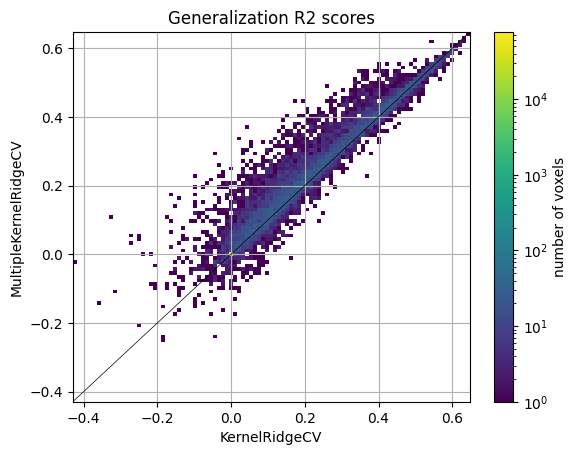

In [23]:
import matplotlib.pyplot as plt
from voxelwise_tutorials.viz import plot_hist2d

ax = plot_hist2d(scores_baseline, scores)
ax.set(title='Generalization R2 scores', xlabel='KernelRidgeCV',
       ylabel='MultipleKernelRidgeCV')
plt.show()

In [24]:
from himalaya.scoring import r2_score_split

Y_test_pred_split = pipeline.predict(X_test, split=True)
split_scores_mask = r2_score_split(Y_test[:, mask], Y_test_pred_split)

print("(n_kernels, n_samples_test, n_voxels_mask) =", Y_test_pred_split.shape)
print("(n_kernels, n_voxels_mask) =", split_scores_mask.shape)

# extend to unfitted voxels
n_kernels = split_scores_mask.shape[0]
n_voxels = Y_train.shape[1]
split_scores = np.zeros((n_kernels, n_voxels))
split_scores[:, mask] = backend.to_numpy(split_scores_mask)
print("(n_kernels, n_voxels) =", split_scores.shape)

(n_kernels, n_samples_test, n_voxels_mask) = (2, 270, 6849)
(n_kernels, n_voxels_mask) = (2, 6849)
(n_kernels, n_voxels) = (2, 84038)


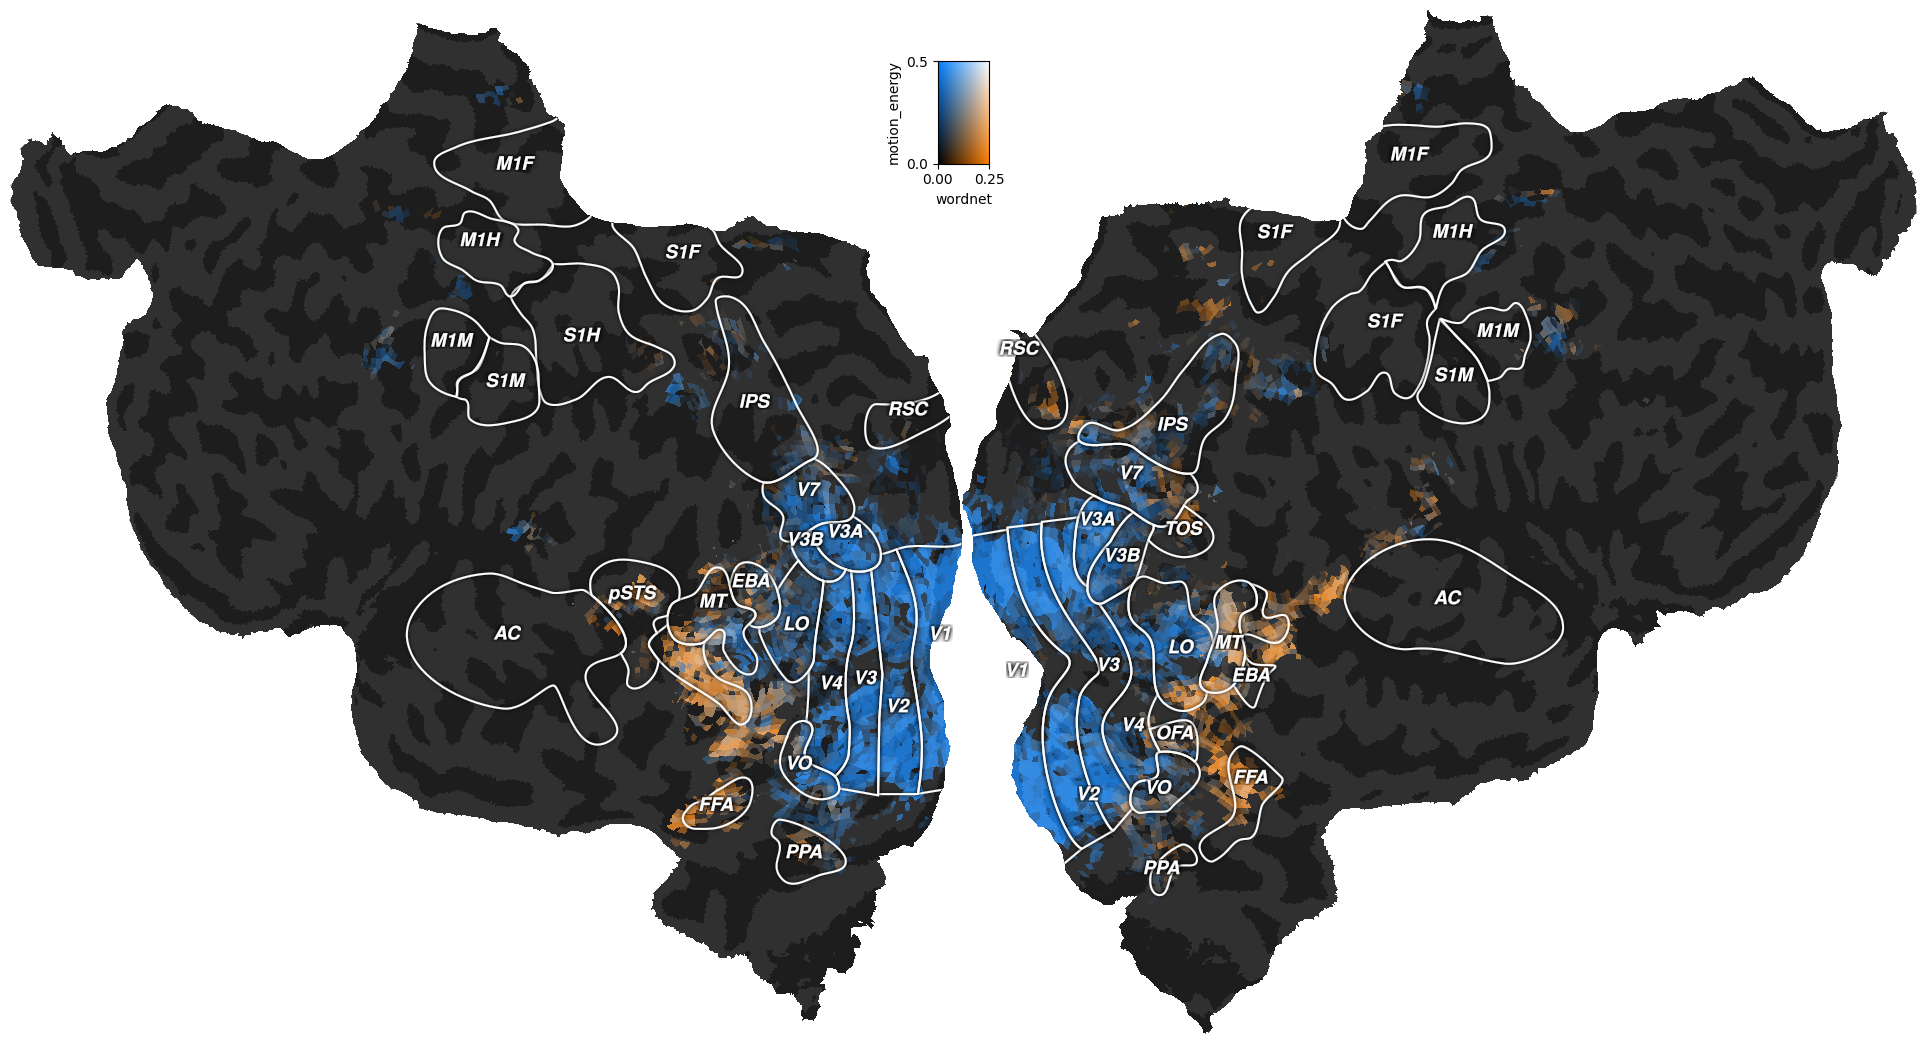

In [25]:
from voxelwise_tutorials.viz import plot_2d_flatmap_from_mapper

mapper_file = os.path.join(directory, "mappers", f"{subject}_mappers.hdf")
ax = plot_2d_flatmap_from_mapper(split_scores[0], split_scores[1],
                                 mapper_file, vmin=0, vmax=0.25, vmin2=0,
                                 vmax2=0.5, label_1=feature_names[0],
                                 label_2=feature_names[1])
plt.show()